<a href="https://colab.research.google.com/github/amyhynes/COMP550-code/blob/master/replication_BERT_wClaimantOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# BERT End to End (Fine-tuning + Predicting) in 5 minutes with Cloud TPU

## Overview

**BERT**, or **B**idirectional **E**mbedding **R**epresentations from **T**ransformers, is a new method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks. The academic paper can be found here: https://arxiv.org/abs/1810.04805.

This Colab demonstates using a free Colab Cloud TPU to fine-tune sentence and sentence-pair classification tasks built on top of pretrained BERT models and 
run predictions on tuned model. The colab demonsrates loading pretrained BERT models from both [TF Hub](https://www.tensorflow.org/hub) and checkpoints.

**Note:**  You will need a GCP (Google Compute Engine) account and a GCS (Google Cloud 
Storage) bucket for this Colab to run.

Please follow the [Google Cloud TPU quickstart](https://cloud.google.com/tpu/docs/quickstart) for how to create GCP account and GCS bucket. You have [$300 free credit](https://cloud.google.com/free/) to get started with any GCP product. You can learn more about Cloud TPU at https://cloud.google.com/tpu/docs.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

## Learning objectives

In this notebook, you will learn how to train and evaluate a BERT model using TPU.

## Instructions

<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on TPU</h3>

   1. Create a Cloud Storage bucket for your TensorBoard logs at http://console.cloud.google.com/storage and fill in the BUCKET parameter in the "Parameters" section below.
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All** (Watch out: the "Colab-only auth for this notebook and the TPU" cell requires user input). You can also run the cells manually with Shift-ENTER.

### Set up your TPU environment

In this section, you perform the following tasks:

*   Set up a Colab TPU running environment
*   Verify that you are connected to a TPU device
*   Upload your credentials to TPU to access your GCS bucket.

In [2]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.42.156.186:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 6872514395822590685),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1326359281831698305),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7477234651503049829),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14716827301385140560),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17301941498205848951),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12434904081387684171),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17042299712573727704),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 2393890155540033285),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 83923655121

### Prepare and import BERT modules
​
With your environment configured, you can now prepare and import the BERT modules. The following step clones the source code from GitHub and import the modules from the source. Alternatively, you can install BERT using pip (!pip install bert-tensorflow).

In [3]:
import sys

!test -d bert_repo || git clone https://github.com/amyhynes/bert.git bert_repo

if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

# import tfhub 
import tensorflow_hub as hub

### Prepare for training

This next section of code performs the following tasks:

*  Specify task and download training data.
*  Specify BERT pretrained model
*  Specify GS bucket, create output directory for model checkpoints and eval results.




In [4]:
TASK = 'LP' #@param {type:"string"}
# Download LeadersPrize data.
#TODO: FIX DOWNLOAD SCRIPT

! test -d LP_data || git clone https://github.com/amyhynes/COMP550-FinalProject.git LP_data

TASK_DATA_DIR = 'LP_data/'
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!ls $TASK_DATA_DIR

BUCKET = 'tb_logs_amy_personal' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}/repl'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

***** Task data directory: LP_data/ *****
dev.tsv  README.md  test.tsv  train.tsv
***** Model output directory: gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl *****


Now let's load tokenizer module from TF Hub

In [5]:
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Also we initilize our hyperprams, prepare the training data and initialize TPU config.

In [6]:
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 128
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

processor = processor = run_classifier.LPProcessorClaimant()
label_list = processor.get_labels()

# Compute number of train and warmup steps from batch size
train_examples = processor.get_train_examples(TASK_DATA_DIR)
num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


# Fine-tune and Run Predictions on a pretrained BERT Model from TF Hub

This section demonstrates fine-tuning from a pre-trained BERT TF Hub module and running predictions.


In [7]:
# Force TF Hub writes to the GS bucket we provide.
os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

model_fn = run_classifier_with_tfhub.model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  bert_hub_module_handle=BERT_MODEL_HUB
)

estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)


INFO:tensorflow:Using config: {'_model_dir': 'gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.42.156.186:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcea28bba90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.42.156.186:8470', '_evaluation_master': 'grpc://10.42.156.186:8470', '_is_chief': 

INFO:tensorflow:Using config: {'_model_dir': 'gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.42.156.186:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcea28bba90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.42.156.186:8470', '_evaluation_master': 'grpc://10.42.156.186:8470', '_is_chief': 

INFO:tensorflow:_TPUContext: eval_on_tpu True


INFO:tensorflow:_TPUContext: eval_on_tpu True


At this point, you can now fine-tune the model, evaluate it, and run predictions on it.

In [0]:
# Train the model
def model_train(estimator):
  print('MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...')
  # We'll set sequences to be at most 128 tokens long.
  train_features = run_classifier.convert_examples_to_features(
      train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started training at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(train_examples)))
  print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('***** Finished training at {} *****'.format(datetime.datetime.now()))



In [9]:
former_ckpt = os.path.join(OUTPUT_DIR,"checkpoint")
!gsutil rm $former_ckpt

model_train(estimator_from_tfhub)

Removing gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/checkpoint...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...



INFO:tensorflow:Writing example 0 of 12166


INFO:tensorflow:Writing example 0 of 12166


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-0


INFO:tensorflow:guid: train-0


INFO:tensorflow:tokens: [CLS] amendment 4 will reduce florida ’ s economic output by $ 34 billion annually . citizens for lower taxes and a stronger economy [SEP]


INFO:tensorflow:tokens: [CLS] amendment 4 will reduce florida ’ s economic output by $ 34 billion annually . citizens for lower taxes and a stronger economy [SEP]


INFO:tensorflow:input_ids: 101 7450 1018 2097 5547 3516 1521 1055 3171 6434 2011 1002 4090 4551 6604 1012 4480 2005 2896 7773 1998 1037 6428 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 7450 1018 2097 5547 3516 1521 1055 3171 6434 2011 1002 4090 4551 6604 1012 4480 2005 2896 7773 1998 1037 6428 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-1


INFO:tensorflow:guid: train-1


INFO:tensorflow:tokens: [CLS] at least 43 % of all food stamp ben ##ef ##icia ##ries are undo ##cum ##ented immigrants . [SEP]


INFO:tensorflow:tokens: [CLS] at least 43 % of all food stamp ben ##ef ##icia ##ries are undo ##cum ##ented immigrants . [SEP]


INFO:tensorflow:input_ids: 101 2012 2560 4724 1003 1997 2035 2833 11359 3841 12879 24108 5134 2024 25672 24894 14088 7489 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2012 2560 4724 1003 1997 2035 2833 11359 3841 12879 24108 5134 2024 25672 24894 14088 7489 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-2


INFO:tensorflow:guid: train-2


INFO:tensorflow:tokens: [CLS] hip ##pop ##ota ##mus ##es are the only animals that produce naturally pink milk . [SEP]


INFO:tensorflow:tokens: [CLS] hip ##pop ##ota ##mus ##es are the only animals that produce naturally pink milk . [SEP]


INFO:tensorflow:input_ids: 101 5099 16340 17287 7606 2229 2024 1996 2069 4176 2008 3965 8100 5061 6501 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5099 16340 17287 7606 2229 2024 1996 2069 4176 2008 3965 8100 5061 6501 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-3


INFO:tensorflow:guid: train-3


INFO:tensorflow:tokens: [CLS] " prince invested in nike in 1971 , recruited nba star michael jordan to the company in 1983 , and designed the first air jordan shoe . " [SEP]


INFO:tensorflow:tokens: [CLS] " prince invested in nike in 1971 , recruited nba star michael jordan to the company in 1983 , and designed the first air jordan shoe . " [SEP]


INFO:tensorflow:input_ids: 101 1000 3159 11241 1999 18368 1999 3411 1010 8733 6452 2732 2745 5207 2000 1996 2194 1999 3172 1010 1998 2881 1996 2034 2250 5207 10818 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 3159 11241 1999 18368 1999 3411 1010 8733 6452 2732 2745 5207 2000 1996 2194 1999 3172 1010 1998 2881 1996 2034 2250 5207 10818 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-4


INFO:tensorflow:guid: train-4


INFO:tensorflow:tokens: [CLS] the amount of the revenue required by the state ( for the construction of high - speed rail ) is around 10 percent . bill nelson [SEP]


INFO:tensorflow:tokens: [CLS] the amount of the revenue required by the state ( for the construction of high - speed rail ) is around 10 percent . bill nelson [SEP]


INFO:tensorflow:input_ids: 101 1996 3815 1997 1996 6599 3223 2011 1996 2110 1006 2005 1996 2810 1997 2152 1011 3177 4334 1007 2003 2105 2184 3867 1012 3021 5912 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3815 1997 1996 6599 3223 2011 1996 2110 1006 2005 1996 2810 1997 2152 1011 3177 4334 1007 2003 2105 2184 3867 1012 3021 5912 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 12166


INFO:tensorflow:Writing example 10000 of 12166


***** Started training at 2019-12-13 01:20:24.404392 *****
  Num examples = 12166
  Batch size = 32
INFO:tensorflow:  Num steps = 1140


INFO:tensorflow:  Num steps = 1140


INFO:tensorflow:Querying Tensorflow master (grpc://10.42.156.186:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.42.156.186:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6872514395822590685)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6872514395822590685)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7477234651503049829)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7477234651503049829)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14716827301385140560)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14716827301385140560)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17301941498205848951)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17301941498205848951)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12434904081387684171)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12434904081387684171)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17042299712573727704)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17042299712573727704)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 2393890155540033285)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 2393890155540033285)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 839236551213553083)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 839236551213553083)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 13840115364601459953)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 13840115364601459953)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 3883593706858792856)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 3883593706858792856)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1326359281831698305)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1326359281831698305)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (4, 128)


INFO:tensorflow:  name = input_ids, shape = (4, 128)


INFO:tensorflow:  name = input_mask, shape = (4, 128)


INFO:tensorflow:  name = input_mask, shape = (4, 128)


INFO:tensorflow:  name = label_ids, shape = (4,)


INFO:tensorflow:  name = label_ids, shape = (4,)


INFO:tensorflow:  name = segment_ids, shape = (4, 128)


INFO:tensorflow:  name = segment_ids, shape = (4, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Saving checkpoints for 1000 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:loss = 0.74834764, step = 1000


INFO:tensorflow:loss = 0.74834764, step = 1000


INFO:tensorflow:Enqueue next (140) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (140) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (140) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (140) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (1, 0)


INFO:tensorflow:Outfeed finished for iteration (1, 0)


INFO:tensorflow:loss = 0.6467913, step = 1140 (10.914 sec)


INFO:tensorflow:loss = 0.6467913, step = 1140 (10.914 sec)


INFO:tensorflow:global_step/sec: 12.8227


INFO:tensorflow:global_step/sec: 12.8227


INFO:tensorflow:examples/sec: 410.326


INFO:tensorflow:examples/sec: 410.326


INFO:tensorflow:Saving checkpoints for 1140 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1140 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Loss for final step: 0.6467913.


INFO:tensorflow:Loss for final step: 0.6467913.


INFO:tensorflow:training_loop marked as finished


INFO:tensorflow:training_loop marked as finished


***** Finished training at 2019-12-13 01:24:16.084902 *****


In [0]:
def model_eval(estimator, eval_examples):
  # Eval the model.
  eval_features = run_classifier.convert_examples_to_features(
      eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(eval_examples)))
  print('  Batch size = {}'.format(EVAL_BATCH_SIZE))

  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(eval_examples) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))


In [11]:
dev_examples = processor.get_dev_examples(TASK_DATA_DIR)
model_eval(estimator_from_tfhub, dev_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-0


INFO:tensorflow:guid: dev-0


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . [SEP]


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . [SEP]


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-1


INFO:tensorflow:guid: dev-1


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo [SEP]


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo [SEP]


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-2


INFO:tensorflow:guid: dev-2


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s [SEP]


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s [SEP]


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-3


INFO:tensorflow:guid: dev-3


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " [SEP]


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " [SEP]


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-4


INFO:tensorflow:guid: dev-4


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . [SEP]


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . [SEP]


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


***** Started evaluation at 2019-12-13 01:24:16.964945 *****
  Num examples = 1520
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-13T01:24:25Z


INFO:tensorflow:Starting evaluation at 2019-12-13T01:24:25Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2019-12-13-01:25:00


INFO:tensorflow:Finished evaluation at 2019-12-13-01:25:00


INFO:tensorflow:Saving dict for global step 1140: eval_accuracy = 0.6381579, eval_loss = 0.9864643, global_step = 1140, loss = 1.041451


INFO:tensorflow:Saving dict for global step 1140: eval_accuracy = 0.6381579, eval_loss = 0.9864643, global_step = 1140, loss = 1.041451


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1140: gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1140: gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2019-12-13 01:25:03.826506 *****
***** Eval results *****
  eval_accuracy = 0.6381579
  eval_loss = 0.9864643
  global_step = 1140
  loss = 1.041451


In [0]:
def model_predict(estimator, prediction_examples):
  # Make predictions on a subset of eval examples
  input_features = run_classifier.convert_examples_to_features(prediction_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
  predictions = estimator.predict(predict_input_fn)

  true = []
  pred = []

  for example, prediction in zip(prediction_examples, predictions):
    # print('text_a: %s\ntext_b: %s\nlabel:%s\nprediction:%s\n' % (example.text_a, example.text_b, str(example.label), prediction['probabilities']))
    true.append(example.label)
    pred.append(np.argmax(prediction['probabilities']))
  return true, pred

In [0]:
import numpy as np

In [15]:
dev_prediction_examples = processor.get_dev_examples(TASK_DATA_DIR)
true, pred = model_predict(estimator_from_tfhub, dev_prediction_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-0


INFO:tensorflow:guid: dev-0


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . [SEP]


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . [SEP]


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-1


INFO:tensorflow:guid: dev-1


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo [SEP]


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo [SEP]


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-2


INFO:tensorflow:guid: dev-2


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s [SEP]


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s [SEP]


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-3


INFO:tensorflow:guid: dev-3


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " [SEP]


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " [SEP]


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-4


INFO:tensorflow:guid: dev-4


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . [SEP]


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . [SEP]


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


[0, 1, 2, 1, 0]
[0, 1, 1, 0, 0]
Confusion matrix, without normalization
[[504 200  23]
 [164 451  15]
 [ 47 101  15]]
Normalized confusion matrix
[[0.69 0.28 0.03]
 [0.26 0.72 0.02]
 [0.29 0.62 0.09]]


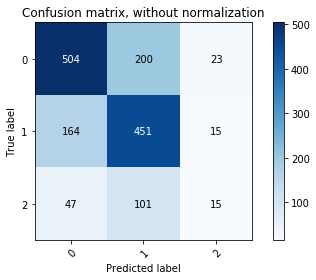

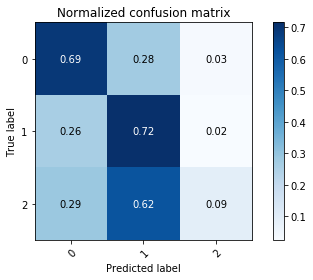

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

y_test = []
y_pred = []

for ind in range(len(true)):
  y_test.append(int(true[ind]))
  y_pred.append(int(pred[ind]))
# y_test = true
# y_pred = pred
class_names = np.array([0,1,2])
print(y_test[:5])

print(y_pred[:5])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
test_eval_examples = processor.get_test_examples(TASK_DATA_DIR)
model_eval(estimator_from_tfhub, test_eval_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-0


INFO:tensorflow:guid: test-0


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " [SEP]


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " [SEP]


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-1


INFO:tensorflow:guid: test-1


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts [SEP]


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts [SEP]


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-2


INFO:tensorflow:guid: test-2


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las [SEP]


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las [SEP]


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-3


INFO:tensorflow:guid: test-3


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund [SEP]


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund [SEP]


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-4


INFO:tensorflow:guid: test-4


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " [SEP]


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " [SEP]


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


***** Started evaluation at 2019-12-13 01:27:49.886772 *****
  Num examples = 1520
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-13T01:27:59Z


INFO:tensorflow:Starting evaluation at 2019-12-13T01:27:59Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


In [0]:
test_prediction_examples = processor.get_test_examples(TASK_DATA_DIR)
test_true, test_pred = model_predict(estimator_from_tfhub, test_prediction_examples)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print("classes first:", classes)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print(classes)
    return ax


np.set_printoptions(precision=2)

y_test = []
y_pred = []

for ind in range(len(test_true)):
  y_test.append(int(test_true[ind]))
  y_pred.append(int(test_pred[ind]))
# y_test = true
# y_pred = pred
class_names = np.array([0,1,2])
print(y_test[:5])

print(y_pred[:5])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()